# Time Series KMeans

In [1]:
import os
import numpy as np
import pandas as pd
import japanize_matplotlib
import matplotlib.pyplot as plt

In [2]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.clustering import silhouette_score

In [17]:
# # -1〜+1の間に規格化
# def normalize(score):
#     norm = (score-score.min())/(score.max()-score.min()) # 0-1に規格化
#     norm = norm * 2
#     norm = norm - np.mean(norm, axis=0)
#     return norm

In [3]:
# 分類されたクラスタを表示
def show_cluster(tm_kmeans, suptitle, title, n_row=3, n_col=3):
    center = tm_kmeans.cluster_centers_[:,:,0]
    plt.figure(figsize=(15, 10))
    plt.suptitle(suptitle, fontsize=20)
    for i in np.arange(len(center)):
        ax = plt.subplot(n_row, n_col, i+1)
        ax.set_title(f'{title}:{i+1}', fontsize=15)
        ax.plot(center[i])
    plt.tight_layout()
    plt.show()

In [4]:
class AozoraTSKmeas:

    def __init__(self, n_clusters, metrics='dtw', random_state=0):
        self.tskmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric=metrics, random_state=random_state)

    def fit_transform(self, A):
        self.A = A
        self.distances = self.tskmeans.fit_transform(self.A)
    
    # 分類されたクラスタを表示
    def show_cluster(self, suptitle, title, n_row=3, n_col=3):
        center = self.tskmeans.cluster_centers_[:,:,0]
        plt.figure(figsize=(15, 10))
        plt.suptitle(suptitle, fontsize=20)
        for i in np.arange(len(center)):
            ax = plt.subplot(n_row, n_col, i+1)
            ax.set_title(f'{title}:{i+1}', fontsize=15)
            ax.plot(center[i])
        plt.tight_layout()
        plt.show()

    # クラスタとクラスタに近いデータを表示
    """
    Parameters
    ----------
    aozora_data: 作家，作品，スコアを含むデータフレーム
    disp_num: クラスタに近いインスタンスの表示数
    label_num: ラベル表示数
    """
    def show_cluster_sumples(self, aozora_data,
                            disp_num=20, label_num=5, 
                            figsize=(15, 15), plot_rows=3, plot_cols=3):
        n_clusters = len(np.unique(self.tskmeans.labels_)) 
        plt.figure(figsize=figsize)
        suptitle = f'tslearn.clustering.TimeSeriesKMeans [metric:dtw][n_clusters={n_clusters}]'
        plt.suptitle(suptitle, fontsize=20)
        for label in range(n_clusters):
            keys = np.where(self.tskmeans.labels_==label)[0]
            values = self.distances[self.tskmeans.labels_==label][:, label]
            distance_dicts = {k: v for k, v in zip(keys, values)}
            distance_dicts_sort = sorted(distance_dicts.items(), key=lambda x:x[1])
            distance_dicts_sort_key = [dict[0] for dict in distance_dicts_sort]
            # print(label, distance_dicts_sort_key[:20])
            # グラフ表示
            cell = label + 1
            ax = plt.subplot(plot_rows, plot_cols, cell)
            count = len(distance_dicts_sort_key)
            top_stories = []
            ax.set_title(f'center{cell} ({count})', fontsize=15)
            for idx in distance_dicts_sort_key[:disp_num]:
                ax.plot(self.A[idx], alpha=.5, c='gray')
                author = aozora_data.iloc[idx].loc['氏名']
                novel = aozora_data.iloc[idx].loc['作品名']
                url = aozora_data.iloc[idx].loc['図書カードURL']
                top_stories.append(f'{novel} ({author})\n{url}')
            xlabel = 'Top Stories:\n'
            for i in range(label_num):
                xlabel = xlabel + f'{str(i+1).zfill(2)}: {top_stories[i]}\n'
            ax.set_xlabel(xlabel, loc='left', fontsize=15)
            # ax.set_xlabel('\n'.join(top_stories[:5]), loc='left', fontsize=15)
            plt.plot(self.tskmeans.cluster_centers_[label].ravel(), c='red')
        plt.tight_layout(rect=[0, 0, 1, 0.98])
        plt.show()
    
    # クラスタに近い小説を表示
    """
    Parameters
    ----------
    kmeans: TimeSeriesKMenasのインスタンス
    distances: 中心からの距離
    aozora_data: 作家，作品，スコアを含むデータフレーム
    disp_num: クラスタに近いインスタンスの表示数
    """
    def show_novels(self, aozora_data, disp_num=20):
        n_clusters = len(np.unique(self.tskmeans.labels_)) 
        print(f'CLUSTER NUM:{n_clusters}')
        print('NO: 作品名 [副題] (作者,文の長さ)\n')
        for label in range(n_clusters):
            keys = np.where(self.tskmeans.labels_==label)[0]
            values = self.distances[self.tskmeans.labels_==label][:, label]
            distance_dicts = {k: v for k, v in zip(keys, values)}
            distance_dicts_sort = sorted(distance_dicts.items(), key=lambda x:x[1])
            distance_dicts_sort_key = [dict[0] for dict in distance_dicts_sort]
            # print(label, distance_dicts_sort_key[:20])
            # クラスタに近い小説を表示
            top_stories = []
            for idx in distance_dicts_sort_key[:disp_num]:
                author = aozora_data.iloc[idx].loc['氏名']
                novel = aozora_data.iloc[idx].loc['作品名']
                subtitle = aozora_data.iloc[idx].loc['副題']
                url = aozora_data.iloc[idx].loc['図書カードURL']
                length = int(aozora_data.iloc[idx].loc['length'])
                if type(subtitle) is float:
                    top_stories.append(f'{novel} ({author},{length})\n{url}')
                else:
                    top_stories.append(f'{novel} [{subtitle}] ({author},{length})\n{url}')
            xlabel = f'Top Stories of center{label+1}:\n'
            for i in range(disp_num):
                xlabel = xlabel + f'{str(i+1).zfill(2)}: {top_stories[i]}\n'
            print(xlabel)

In [6]:
# 使うデータは1149冊分の小説データの感情スコア値
SCORE_PATH = 'data/all_score_1008.csv'
TARGET_PATH = 'data/target2.csv'

In [8]:
# スコアファイル読み込み
score_df = pd.read_csv(SCORE_PATH, index_col=0)
print(score_df.shape)
score_df.head()

(1149, 100)


S00       S01       S02       S03       S04       S05       S06  \
13  0.179309  0.204774  0.250307  0.328534  0.288642  0.333355  0.339418   
19  0.815028  0.804822  0.799345  0.787488  0.809651  0.800542  0.793770   
24  0.134988  0.230654  0.174346  0.101856  0.128532  0.156816  0.162320   
30  0.299781  0.308730  0.352671  0.225923  0.177187  0.263826  0.224948   
41  0.961162  1.000000  0.892365  0.752871  0.736579  0.797382  0.817146   

         S07       S08       S09  ...       S90       S91       S92       S93  \
13  0.405366  0.405227  0.414494  ...  0.794562  0.800324  0.832745  0.835058   
19  0.822233  0.864655  0.868022  ...  0.854319  0.840318  0.884111  0.808352   
24  0.185283  0.298942  0.422190  ...  0.326948  0.338318  0.313528  0.212145   
30  0.183702  0.126800  0.253343  ...  0.127586  0.021276  0.020974  0.107997   
41  0.866989  0.803572  0.771882  ...  0.489015  0.634855  0.706302  0.892260   

         S94       S95       S96       S97       S98       S99  
13  0.878649  0.935813  0.988501  1.000000  0.998376  0.955127  
19  0.775783  0.863060  0.826472  0.868709  0.822273  0.732512  
24  0.117914  0.089339  0.031072  0.000000  0.063481  0.175065  
30  0.000000  0.035970  0.048028  0.013692  0.042874  0.311243  
41  0.824996  0.763573  0.752663  0.801418  0.886343  0.920387  

[5 rows x 100 columns]

In [9]:
# ターゲットファイル読み込み
target_df = pd.read_csv(TARGET_PATH, index_col=0)
target_df.head(2)

対象  人物ID      氏名            読み   作品ID    作品名   副題        作品名読み  \
0  True   374   饗庭 篁村      あえば こうそん  45754     良夜  NaN         りょうや   
1  True   879  芥川 竜之介  あくたがわ りゅうのすけ     73  或敵打の話  NaN  あるかたきうちのはなし   

                                            図書カードURL  \
0  https://www.aozora.gr.jp/cards/000374/card4575...   
1  https://www.aozora.gr.jp/cards/000879/card73.html   

                                         テキストファイルURL  \
0  https://www.aozora.gr.jp/cards/000374/files/45...   
1  https://www.aozora.gr.jp/cards/000879/files/73...   

                                          テキストファイルパス  \
0  ./bunko/cards/000374/files/edit/45754_ruby_236...   
1   ./bunko/cards/000879/files/edit/73_ruby_1217.txt   

                                           スコアファイルパス   備考  length  
0  ./bunko/cards/000374/files/score/45754_ruby_23...  NaN   119.0  
1  ./bunko/cards/000879/files/score/73_ruby_1217.txt  NaN   280.0

In [10]:
# ターゲットファイルとスコアファイルをマージ
df_merge_all = pd.merge(target_df, score_df, left_index=True, right_index=True)
df_merge_all.head(3)

対象  人物ID      氏名            読み  作品ID     作品名   副題     作品名読み  \
13  True   879  芥川 竜之介  あくたがわ りゅうのすけ   124  お律と子等と  NaN   おりつとこらと   
19  True   879  芥川 竜之介  あくたがわ りゅうのすけ    69      河童  NaN       かっぱ   
24  True   879  芥川 竜之介  あくたがわ りゅうのすけ    77   奇怪な再会  NaN  きかいなさいかい   

                                             図書カードURL  \
13  https://www.aozora.gr.jp/cards/000879/card124....   
19  https://www.aozora.gr.jp/cards/000879/card69.html   
24  https://www.aozora.gr.jp/cards/000879/card77.html   

                                          テキストファイルURL  ...       S90  \
13  https://www.aozora.gr.jp/cards/000879/files/12...  ...  0.794562   
19  https://www.aozora.gr.jp/cards/000879/files/69...  ...  0.854319   
24  https://www.aozora.gr.jp/cards/000879/files/77...  ...  0.326948   

         S91       S92       S93       S94       S95       S96       S97  \
13  0.800324  0.832745  0.835058  0.878649  0.935813  0.988501  1.000000   
19  0.840318  0.884111  0.808352  0.775783  0.863060  0.826472  0.868709   
24  0.338318  0.313528  0.212145  0.117914  0.089339  0.031072  0.000000   

         S98       S99  
13  0.998376  0.955127  
19  0.822273  0.732512  
24  0.063481  0.175065  

[3 rows x 114 columns]

In [11]:
# Indexを列として出して，振り直し
df_merge = df_merge_all.reset_index()
df_merge = df_merge.rename(columns={'index': 'TargetID'})
df_merge.head()

TargetID    対象  人物ID      氏名            読み  作品ID     作品名   副題     作品名読み  \
0        13  True   879  芥川 竜之介  あくたがわ りゅうのすけ   124  お律と子等と  NaN   おりつとこらと   
1        19  True   879  芥川 竜之介  あくたがわ りゅうのすけ    69      河童  NaN       かっぱ   
2        24  True   879  芥川 竜之介  あくたがわ りゅうのすけ    77   奇怪な再会  NaN  きかいなさいかい   
3        30  True   879  芥川 竜之介  あくたがわ りゅうのすけ    38    戯作三昧  NaN   げさくざんまい   
4        41  True   879  芥川 竜之介  あくたがわ りゅうのすけ    59     邪宗門  NaN   じゃしゅうもん   

                                            図書カードURL  ...       S90       S91  \
0  https://www.aozora.gr.jp/cards/000879/card124....  ...  0.794562  0.800324   
1  https://www.aozora.gr.jp/cards/000879/card69.html  ...  0.854319  0.840318   
2  https://www.aozora.gr.jp/cards/000879/card77.html  ...  0.326948  0.338318   
3  https://www.aozora.gr.jp/cards/000879/card38.html  ...  0.127586  0.021276   
4  https://www.aozora.gr.jp/cards/000879/card59.html  ...  0.489015  0.634855   

        S92       S93       S94       S95       S96       S97       S98  \
0  0.832745  0.835058  0.878649  0.935813  0.988501  1.000000  0.998376   
1  0.884111  0.808352  0.775783  0.863060  0.826472  0.868709  0.822273   
2  0.313528  0.212145  0.117914  0.089339  0.031072  0.000000  0.063481   
3  0.020974  0.107997  0.000000  0.035970  0.048028  0.013692  0.042874   
4  0.706302  0.892260  0.824996  0.763573  0.752663  0.801418  0.886343   

        S99  
0  0.955127  
1  0.732512  
2  0.175065  
3  0.311243  
4  0.920387  

[5 rows x 115 columns]

In [12]:
# スコアだけ表示してみる
df_merge.loc[:,'S00':]

S00       S01       S02       S03       S04       S05       S06  \
0     0.179309  0.204774  0.250307  0.328534  0.288642  0.333355  0.339418   
1     0.815028  0.804822  0.799345  0.787488  0.809651  0.800542  0.793770   
2     0.134988  0.230654  0.174346  0.101856  0.128532  0.156816  0.162320   
3     0.299781  0.308730  0.352671  0.225923  0.177187  0.263826  0.224948   
4     0.961162  1.000000  0.892365  0.752871  0.736579  0.797382  0.817146   
...        ...       ...       ...       ...       ...       ...       ...   
1144  0.659664  0.617009  0.573119  0.596463  0.538444  0.452620  0.441036   
1145  0.537027  0.729001  0.707587  0.686109  0.630949  0.562731  0.491545   
1146  0.716008  0.599519  0.355020  0.237947  0.250619  0.273733  0.359095   
1147  0.859603  0.795878  0.765592  0.742433  0.760949  0.762056  0.854166   
1148  1.000000  0.972442  0.984888  0.976434  0.933068  0.864823  0.804197   

           S07       S08       S09  ...       S90       S91       S92  \
0     0.405366  0.405227  0.414494  ...  0.794562  0.800324  0.832745   
1     0.822233  0.864655  0.868022  ...  0.854319  0.840318  0.884111   
2     0.185283  0.298942  0.422190  ...  0.326948  0.338318  0.313528   
3     0.183702  0.126800  0.253343  ...  0.127586  0.021276  0.020974   
4     0.866989  0.803572  0.771882  ...  0.489015  0.634855  0.706302   
...        ...       ...       ...  ...       ...       ...       ...   
1144  0.357046  0.347755  0.377295  ...  0.230913  0.178094  0.166528   
1145  0.524073  0.505473  0.562925  ...  0.736264  0.731289  0.736449   
1146  0.434954  0.619497  0.701458  ...  0.287079  0.490301  0.630845   
1147  0.922393  0.854709  0.861513  ...  0.567328  0.581575  0.617135   
1148  0.716612  0.642365  0.575632  ...  0.305522  0.330568  0.308917   

           S93       S94       S95       S96       S97       S98       S99  
0     0.835058  0.878649  0.935813  0.988501  1.000000  0.998376  0.955127  
1     0.808352  0.775783  0.863060  0.826472  0.868709  0.822273  0.732512  
2     0.212145  0.117914  0.089339  0.031072  0.000000  0.063481  0.175065  
3     0.107997  0.000000  0.035970  0.048028  0.013692  0.042874  0.311243  
4     0.892260  0.824996  0.763573  0.752663  0.801418  0.886343  0.920387  
...        ...       ...       ...       ...       ...       ...       ...  
1144  0.169163  0.188663  0.136154  0.229215  0.290823  0.350349  0.441553  
1145  0.769499  0.822682  1.000000  0.973882  0.908806  0.994381  0.806542  
1146  0.716586  0.864967  0.826656  0.562636  0.565184  0.726931  0.786824  
1147  0.658563  0.597537  0.678438  0.634325  0.552235  0.549418  0.680607  
1148  0.331619  0.420613  0.458276  0.509699  0.531359  0.517578  0.482399  

[1149 rows x 100 columns]

In [13]:
scores = df_merge.loc[:,'S00':].to_numpy()
# scores = score_df.to_numpy()

In [14]:
# 平均値を０にしておく(-1〜1の間に規格化)
A = scores.copy()
# A = normalize(scores)
# A = scores - scores.mean(axis=0)
A.shape, np.min(A), np.max(A), np.mean(A)

((1149, 100), 0.0, 1.0, 0.49622451348491037)

In [15]:
# 軸を追加しておく
A = A[:,:,np.newaxis]
A.shape

(1149, 100, 1)

## metric:euclidean

In [17]:
km1 = TimeSeriesKMeans(n_clusters=9, metric='euclidean', random_state=0)
km1.fit(A)

TimeSeriesKMeans(n_clusters=9, random_state=0)

In [18]:
km1.cluster_centers_.shape

(9, 100, 1)

In [19]:
center1 = km1.cluster_centers_[:,:,0]
center1.shape

(9, 100)

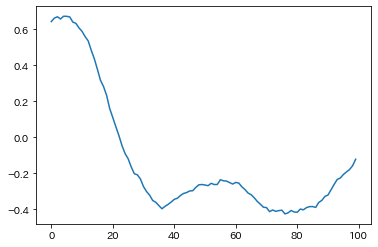

In [20]:
plt.plot(center1[2])

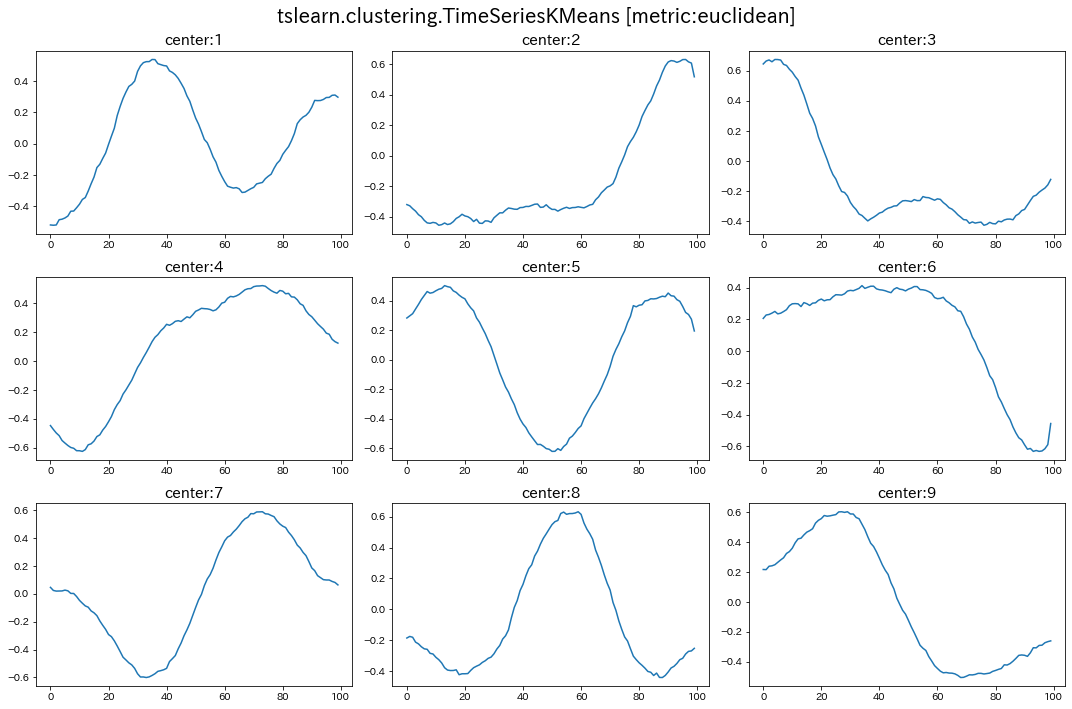

In [21]:
# 視覚化
suptitle = 'tslearn.clustering.TimeSeriesKMeans [metric:euclidean]'
show_cluster(km1, suptitle, 'center')

## metric:dtw

In [22]:
km2 = TimeSeriesKMeans(n_clusters=9, metric='dtw', random_state=0)
km2.fit(A)

TimeSeriesKMeans(metric='dtw', n_clusters=9, random_state=0)

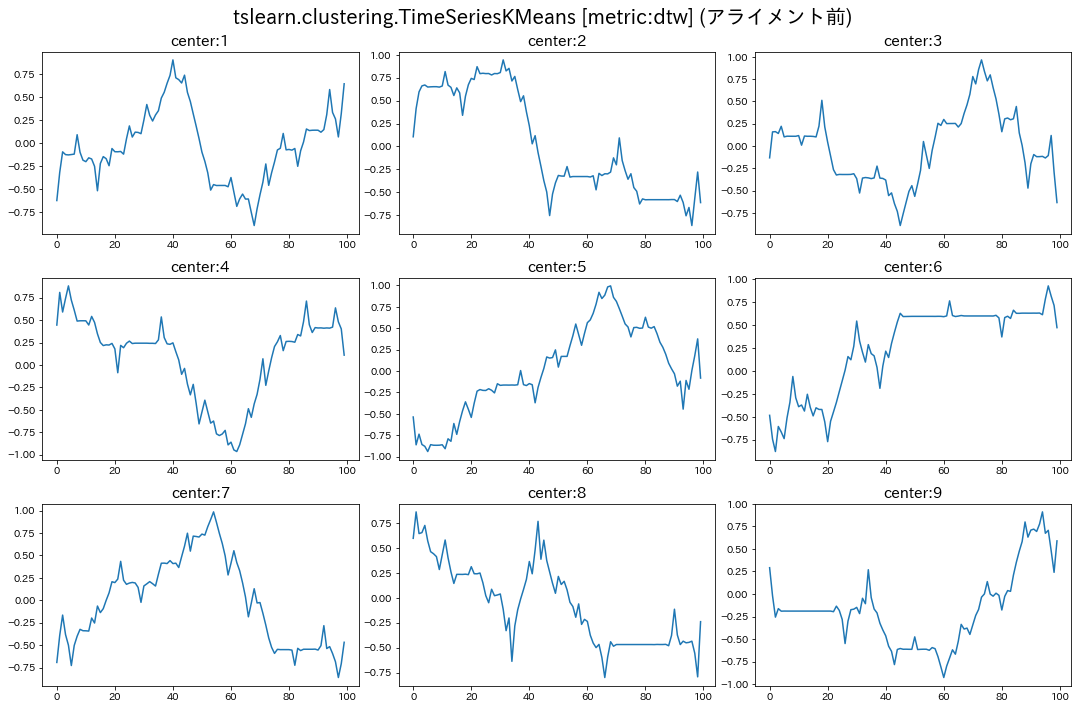

In [23]:
suptitle = 'tslearn.clustering.TimeSeriesKMeans [metric:dtw] (アライメント前)'
show_cluster(km2, suptitle, 'center')

In [24]:
np.unique(km2.labels_)

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [25]:
km2_pred = km2.predict(A)

In [26]:
distances = km2.transform(A)
distances.shape

(1149, 9)

In [27]:
np.where(km2.labels_==0)[0].shape

(113,)

In [28]:
keys = np.where(km2.labels_==0)[0]
values = distances[km2.labels_==0][:, 0]
distance_dicts = {k: v for k, v in zip(keys, values)}
distance_dicts_sort = sorted(distance_dicts.items(), key=lambda x:x[1])
# np.where(km2.labels_==0)[0], distances[km2.labels_==0][:, 0]

In [29]:
distance_dicts_sort_key = [dict[0] for dict in distance_dicts_sort]
print(distance_dicts_sort_key[:20])

[857, 684, 522, 1063, 374, 660, 879, 877, 453, 1065, 699, 784, 36, 231, 234, 938, 639, 1120, 33, 1071]


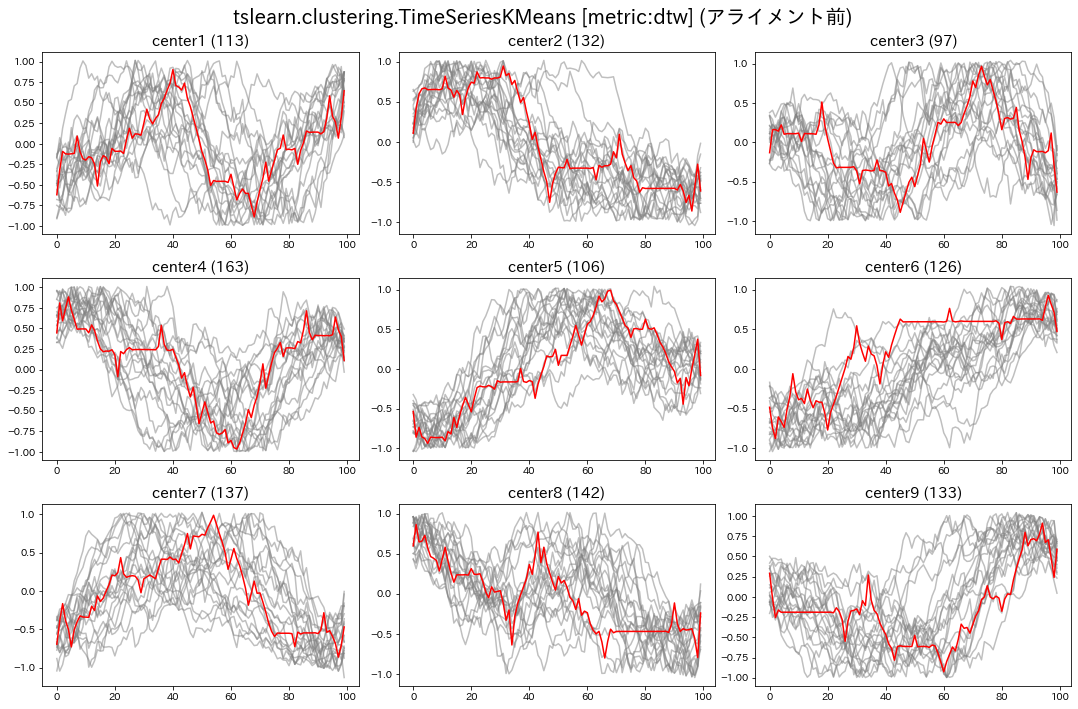

In [30]:
n_clusters = len(np.unique(km2.labels_)) 
disp_num = 20
plt.figure(figsize=(15, 10))
plt.suptitle('tslearn.clustering.TimeSeriesKMeans [metric:dtw] (アライメント前)', fontsize=20)
for label in range(n_clusters):
    keys = np.where(km2.labels_==label)[0]
    values = distances[km2.labels_==label][:, label]
    distance_dicts = {k: v for k, v in zip(keys, values)}
    distance_dicts_sort = sorted(distance_dicts.items(), key=lambda x:x[1])
    distance_dicts_sort_key = [dict[0] for dict in distance_dicts_sort]
    # print(label, distance_dicts_sort_key[:20])
    # グラフ表示
    cell = label + 1
    ax = plt.subplot(3, 3, cell)
    count = len(distance_dicts_sort_key)
    ax.set_title(f'center{cell} ({count})', fontsize=15)    
    for idx in distance_dicts_sort_key[:disp_num]:
        ax.plot(A[idx], alpha=.5, c='gray')
    plt.plot(km2.cluster_centers_[label].ravel(), c='red')
plt.tight_layout()
plt.show()

## metric:softdtw

In [31]:
# 遅いです．．
km3 = TimeSeriesKMeans(n_clusters=9, metric='softdtw', random_state=0)
km3.fit(A)

TimeSeriesKMeans(metric='softdtw', n_clusters=9, random_state=0)

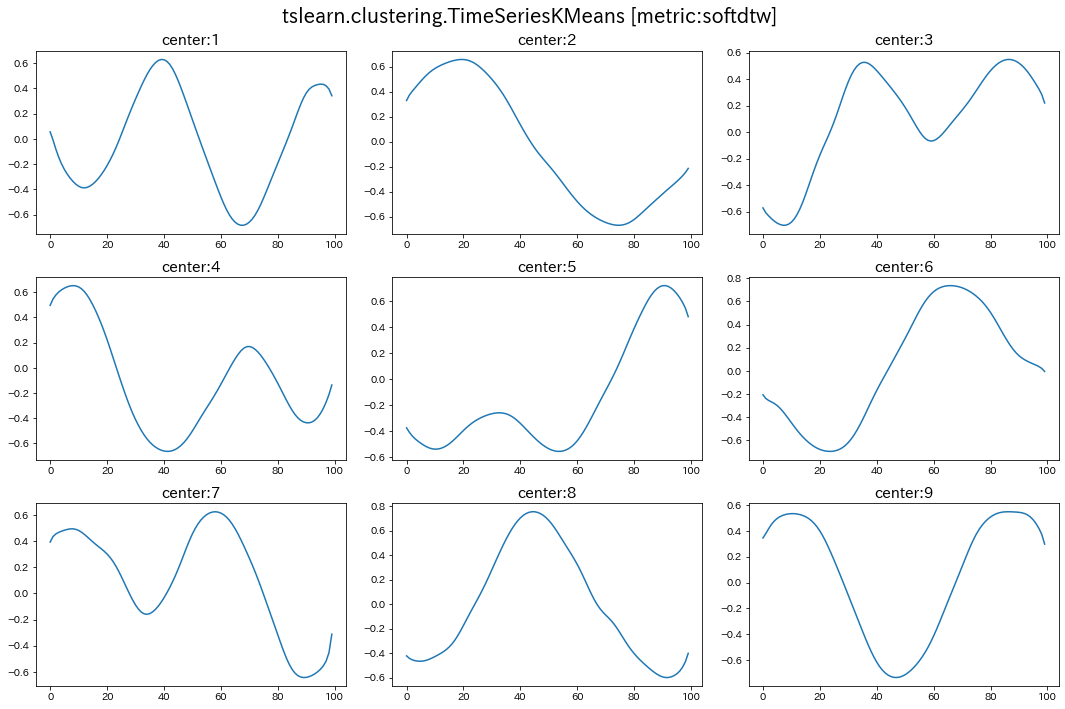

In [32]:
suptitle = 'tslearn.clustering.TimeSeriesKMeans [metric:softdtw]'
show_cluster(km3, suptitle, 'center')

## エルボー法

In [33]:
distortions = []
tskms = []
for n in range(1, 11):
    print('n_clusters:', n)
    km = TimeSeriesKMeans(n_clusters=n, metric='dtw', random_state=0)
    km.fit(A)
    tskms.append(km)
    distortions.append(km.inertia_)

n_clusters: 1
n_clusters: 2
n_clusters: 3
n_clusters: 4
n_clusters: 5
n_clusters: 6
n_clusters: 7
n_clusters: 8
n_clusters: 9
n_clusters: 10


In [34]:
# 作成したモデルを保存しておく
for i in range(len(tskms)):
    # print(i, f'data/tskm_cluster{i+1}.hdf5')
    file_path = f'data/tskm_cluster{i+1}.hdf5'
    if os.path.isfile(file_path):
        os.remove(file_path)
    tskms[i].to_hdf5(file_path)

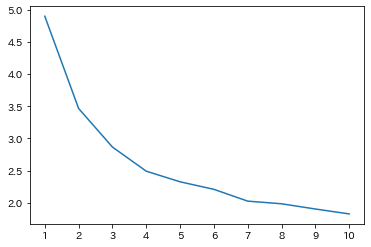

In [35]:
plt.plot(distortions)
plt.xticks(range(10), range(1,11))
plt.show()

## シルエット法

In [36]:
# シルエット法で検証する
silhouette_scores = []
for n in range(1, 10):
    print(f'calc.. silhouette score [cluster{n+1}]')
    ss = silhouette_score(A, tskms[n].labels_, 'dtw')
    silhouette_scores.append(ss)
    print(f'silhouette score [cluster{n+1}]: {ss}')

calc.. silhouette score [cluster2]
silhouette score [cluster2]: 0.30475315160740213
calc.. silhouette score [cluster3]
silhouette score [cluster3]: 0.2624223152673523
calc.. silhouette score [cluster4]
silhouette score [cluster4]: 0.2433486885809334
calc.. silhouette score [cluster5]
silhouette score [cluster5]: 0.23514452699328728
calc.. silhouette score [cluster6]
silhouette score [cluster6]: 0.17673368863061537
calc.. silhouette score [cluster7]
silhouette score [cluster7]: 0.17697672352115104
calc.. silhouette score [cluster8]
silhouette score [cluster8]: 0.1708650166615113
calc.. silhouette score [cluster9]
silhouette score [cluster9]: 0.15170727714026133
calc.. silhouette score [cluster10]
silhouette score [cluster10]: 0.16135947880932405


In [37]:
for i in range(len(silhouette_scores)):
    print(f'silhouette score [cluster{i+2}]: {round(silhouette_scores[i],3)}')

silhouette score [cluster2]: 0.305
silhouette score [cluster3]: 0.262
silhouette score [cluster4]: 0.243
silhouette score [cluster5]: 0.235
silhouette score [cluster6]: 0.177
silhouette score [cluster7]: 0.177
silhouette score [cluster8]: 0.171
silhouette score [cluster9]: 0.152
silhouette score [cluster10]: 0.161


In [38]:
# シルエットスコアを保存しておく
np.save('data/silhouette_scores.npy', np.array(silhouette_scores))

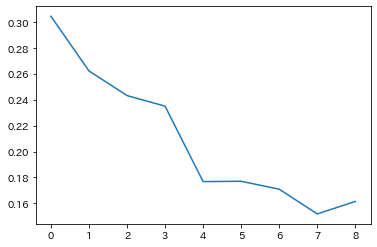

In [39]:
sil_scores = np.load('data/silhouette_scores.npy')
plt.plot(sil_scores)
plt.show()

In [40]:
# 保存されたファイルからロードする場合は以下を実施
tskms = []
for n in range(10):
    file_path = f'data/tskm_cluster{n+1}.hdf5'
    if os.path.isfile(file_path):
        print(f'Load: tskms[{n}]=',file_path, )
        tskms.append(TimeSeriesKMeans.from_hdf5(file_path))
    else:
        print('Skip: ',file_path)

Load: tskms[0]= data/tskm_cluster1.hdf5
Load: tskms[1]= data/tskm_cluster2.hdf5
Load: tskms[2]= data/tskm_cluster3.hdf5
Load: tskms[3]= data/tskm_cluster4.hdf5
Load: tskms[4]= data/tskm_cluster5.hdf5
Load: tskms[5]= data/tskm_cluster6.hdf5
Load: tskms[6]= data/tskm_cluster7.hdf5
Load: tskms[7]= data/tskm_cluster8.hdf5
Load: tskms[8]= data/tskm_cluster9.hdf5
Load: tskms[9]= data/tskm_cluster10.hdf5


In [41]:
silhouette_score(A, tskms[3].labels_, 'dtw')

0.2433486885809334

In [42]:
silhouette_score(A, tskms[5].labels_, 'dtw')

0.17673368863061537

## クラスタ数:4

In [16]:
import pickle
def save_instance(obj, file_path):
    with open(file_path, 'wb') as p:
        pickle.dump(obj, p)

def load_instance(file_path):
    with open(file_path, 'rb') as p:
        return pickle.load(p)

In [26]:
# クラスタ数:4で実施
file_path = 'data/km4.bin'
if os.path.isfile(file_path):
    km4 = load_instance(file_path)
else:
    km4 = AozoraTSKmeas(4)
    km4.fit_transform(A)
    save_instance(km4, file_path)

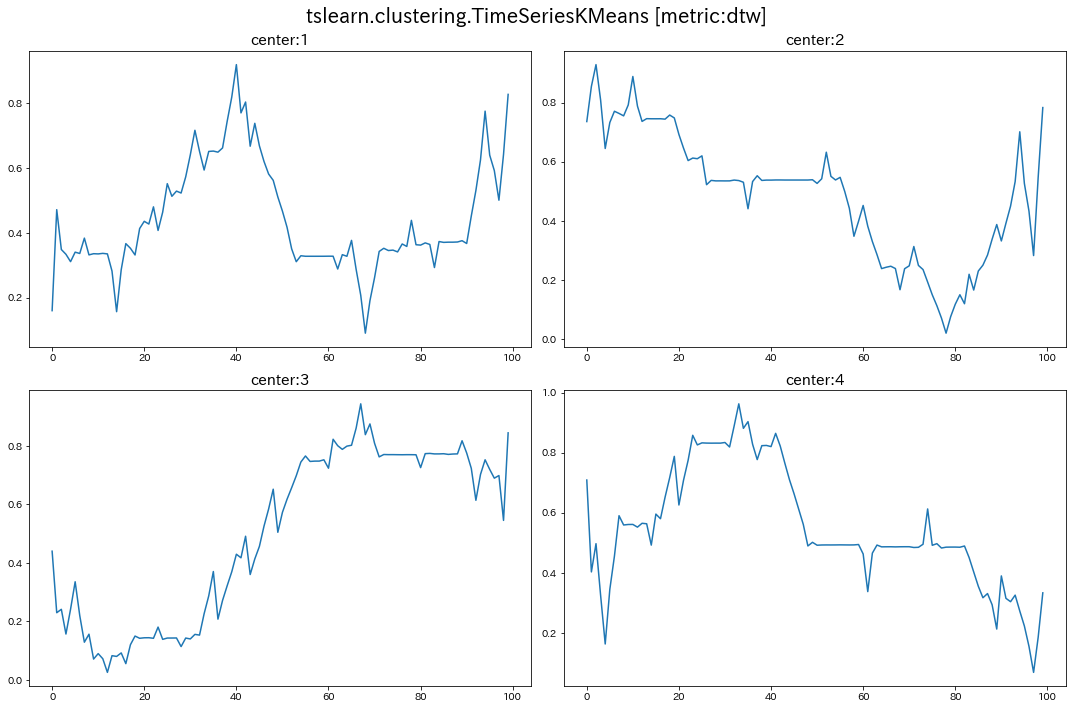

In [27]:
# 視覚化
suptitle = 'tslearn.clustering.TimeSeriesKMeans [metric:dtw]'
km4.show_cluster(suptitle, 'center', 2, 2)

In [28]:
# クラスタ付近の小説を表示
km4.show_novels(df_merge, 5)

CLUSTER NUM:4
NO: 作品名 [副題] (作者,文の長さ)

Top Stories of center1:
01: 職工と微笑 (松永 延造,2401)
https://www.aozora.gr.jp/cards/000104/card541.html
02: 花火 (太宰 治,624)
https://www.aozora.gr.jp/cards/000035/card264.html
03: 道づれ (宮本 百合子,626)
https://www.aozora.gr.jp/cards/000311/card1995.html
04: 雪解 (永井 荷風,534)
https://www.aozora.gr.jp/cards/001341/card58077.html
05: 古狢 (泉 鏡花,621)
https://www.aozora.gr.jp/cards/000050/card3549.html

Top Stories of center2:
01: 支那米の袋 (夢野 久作,647)
https://www.aozora.gr.jp/cards/000096/card2101.html
02: 心霊殺人事件 (坂口 安吾,840)
https://www.aozora.gr.jp/cards/001095/card43247.html
03: 仁王門 (橘 外男,642)
https://www.aozora.gr.jp/cards/001397/card49870.html
04: 湖畔 (久生 十蘭,583)
https://www.aozora.gr.jp/cards/001224/card46090.html
05: その一年 (山川 方夫,1406)
https://www.aozora.gr.jp/cards/001801/card57062.html

Top Stories of center3:
01: 私本太平記 [07 千早帖] (吉川 英治,4885)
https://www.aozora.gr.jp/cards/001562/card52427.html
02: 秀才養子鑑 (佐々木 邦,809)
https://www.aozora.gr.jp/cards/001750/card55816.html
0

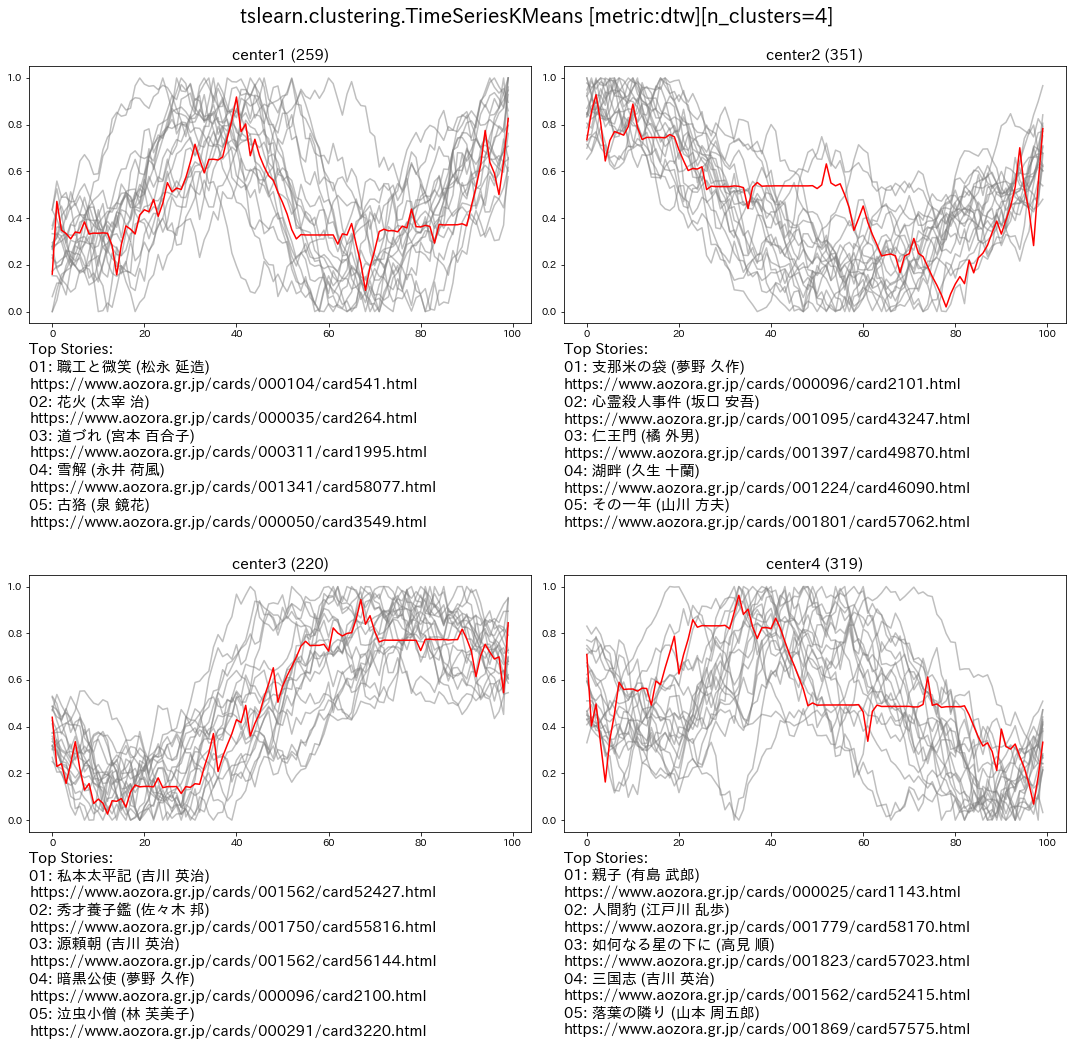

In [29]:
# クラスタとその付近の小説を視覚化
km4.show_cluster_sumples(df_merge, plot_rows=2, plot_cols=2, disp_num=20)

## クラスタ数:5

In [21]:
# クラスタ数:5で実施
file_path = 'data/km5.bin'
if os.path.isfile(file_path):
    km5 = load_instance(file_path)
else:
    km5 = AozoraTSKmeas(5)
    km5.fit_transform(A)
    save_instance(km5, file_path)

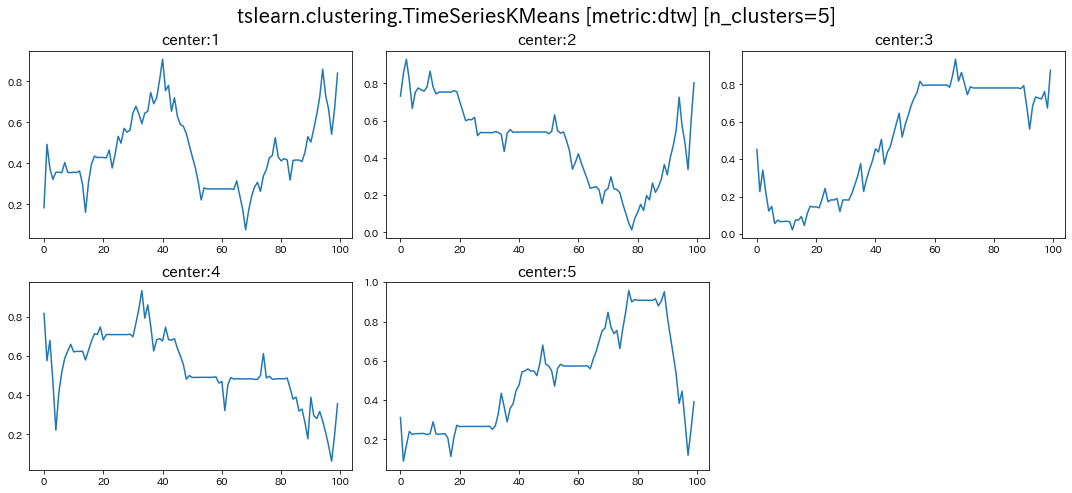

In [22]:
# 視覚化
suptitle = 'tslearn.clustering.TimeSeriesKMeans [metric:dtw] [n_clusters=5]'
km5.show_cluster(suptitle, 'center')

In [23]:
# クラスタ付近の小説を表示
km5.show_novels(df_merge, 5)

CLUSTER NUM:5
NO: 作品名 [副題] (作者,文の長さ)

Top Stories of center1:
01: 職工と微笑 (松永 延造,2401)
https://www.aozora.gr.jp/cards/000104/card541.html
02: 大菩薩峠 [17 黒業白業の巻] (中里 介山,2192)
https://www.aozora.gr.jp/cards/000283/card4503.html
03: 花火 (太宰 治,624)
https://www.aozora.gr.jp/cards/000035/card264.html
04: 花と龍 (火野 葦平,15513)
https://www.aozora.gr.jp/cards/001488/card56224.html
05: 南国太平記 (直木 三十五,21879)
https://www.aozora.gr.jp/cards/000216/card45567.html

Top Stories of center2:
01: 支那米の袋 (夢野 久作,647)
https://www.aozora.gr.jp/cards/000096/card2101.html
02: 心霊殺人事件 (坂口 安吾,840)
https://www.aozora.gr.jp/cards/001095/card43247.html
03: 湖畔 (久生 十蘭,583)
https://www.aozora.gr.jp/cards/001224/card46090.html
04: 赤ひげ診療譚 [04 三度目の正直] (山本 周五郎,534)
https://www.aozora.gr.jp/cards/001869/card57842.html
05: 銭形平次捕物控 [096 忍術指南] (野村 胡堂,517)
https://www.aozora.gr.jp/cards/001670/card56365.html

Top Stories of center3:
01: 私本太平記 [07 千早帖] (吉川 英治,4885)
https://www.aozora.gr.jp/cards/001562/card52427.html
02: 泣虫小僧 (林 芙美子,1224)


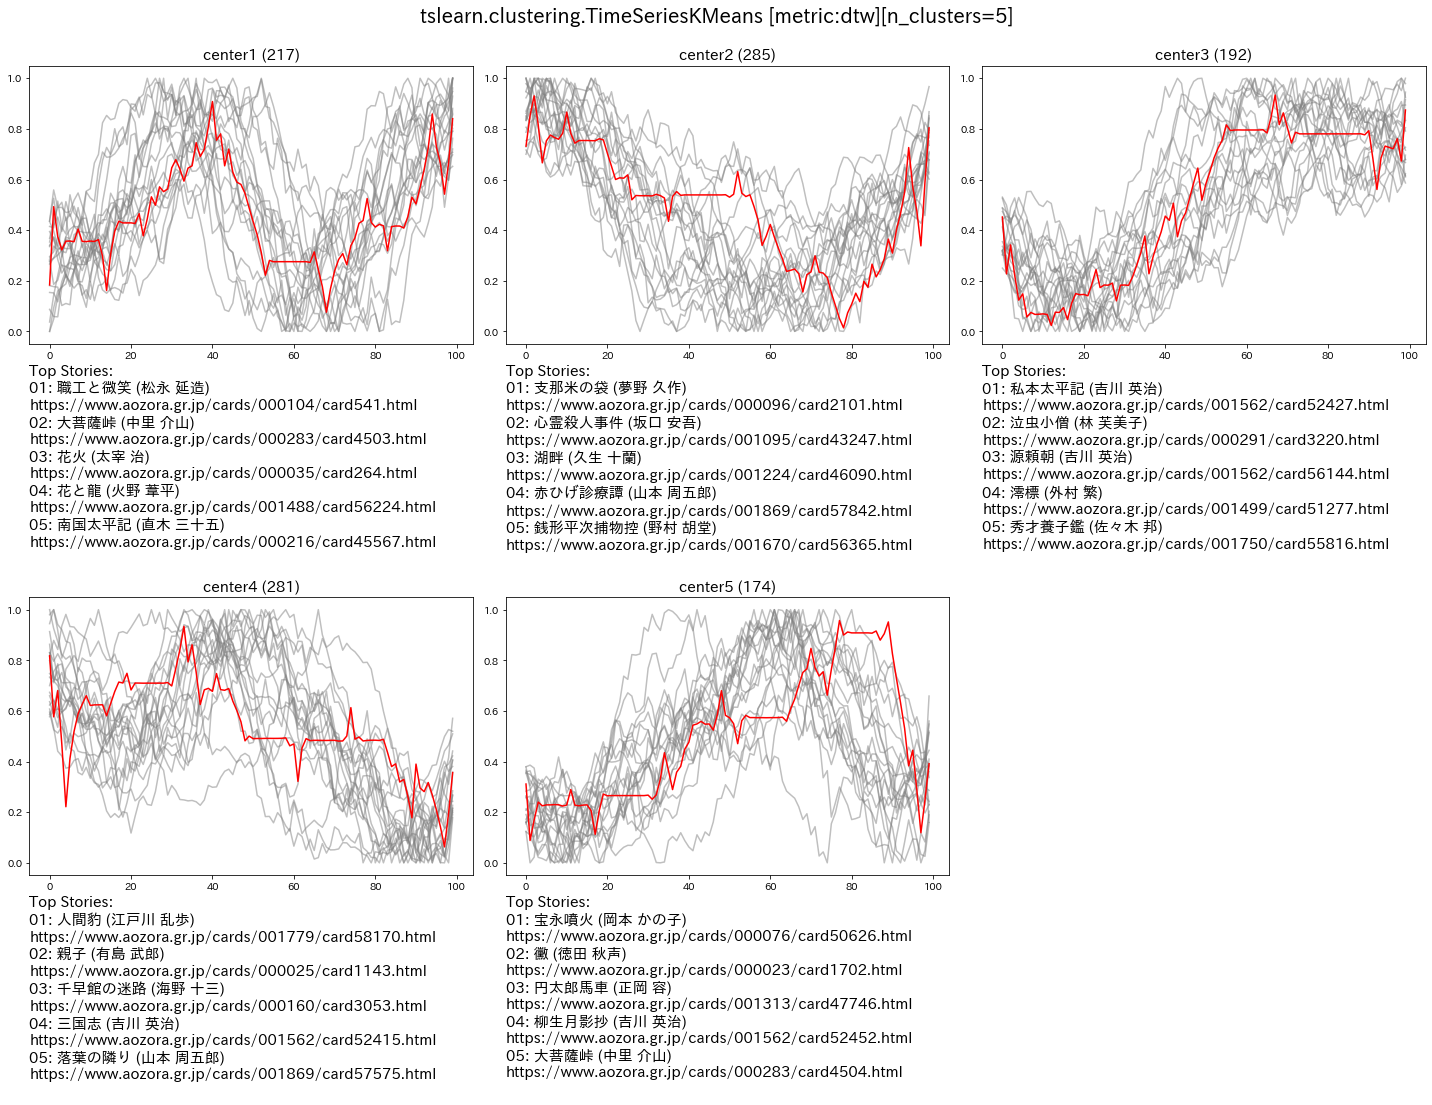

In [24]:
# クラスタとその付近の小説を視覚化
km5.show_cluster_sumples(df_merge, plot_rows=3, plot_cols=3, figsize=(20, 20))

## クラスタ数:6

In [31]:
# クラスタ数:6で実施
file_path = 'data/km6.bin'
if os.path.isfile(file_path):
    km6 = load_instance(file_path)
else:
    km6 = AozoraTSKmeas(6)
    km6.fit_transform(A)
    save_instance(km6, file_path)

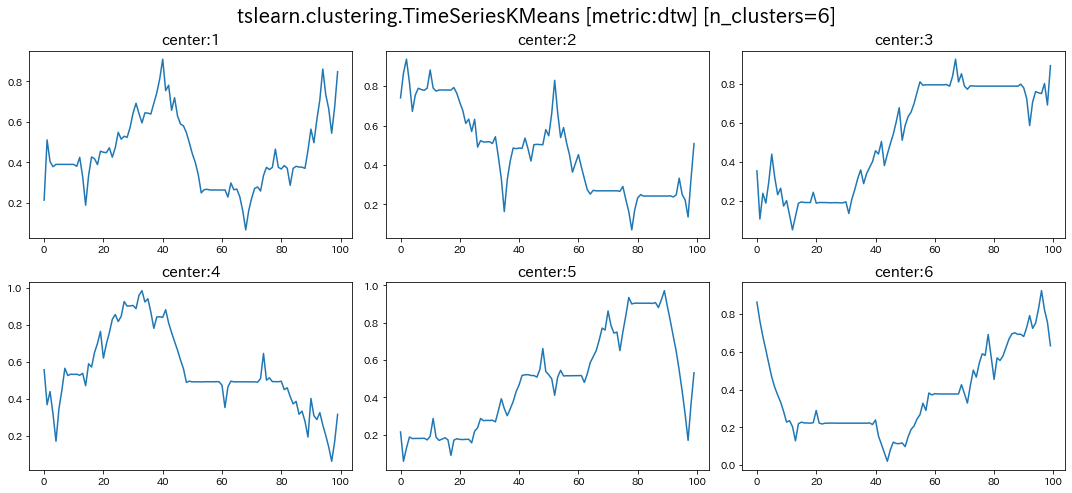

In [32]:
# 視覚化
suptitle = 'tslearn.clustering.TimeSeriesKMeans [metric:dtw] [n_clusters=6]'
km6.show_cluster(suptitle, 'center')

In [33]:
# クラスタ付近の小説を表示
km6.show_novels(df_merge, 5)

CLUSTER NUM:6
NO: 作品名 [副題] (作者,文の長さ)

Top Stories of center1:
01: 職工と微笑 (松永 延造,2401)
https://www.aozora.gr.jp/cards/000104/card541.html
02: 花火 (太宰 治,624)
https://www.aozora.gr.jp/cards/000035/card264.html
03: 七日七夜 (山本 周五郎,536)
https://www.aozora.gr.jp/cards/001869/card57691.html
04: 南国太平記 (直木 三十五,21879)
https://www.aozora.gr.jp/cards/000216/card45567.html
05: 中庸 (坂口 安吾,590)
https://www.aozora.gr.jp/cards/001095/card42949.html

Top Stories of center2:
01: 女記者の役割 (野村 胡堂,503)
https://www.aozora.gr.jp/cards/001670/card56703.html
02: Ｐ丘の殺人事件 (松本 泰,645)
https://www.aozora.gr.jp/cards/000308/card46590.html
03: その一年 (山川 方夫,1406)
https://www.aozora.gr.jp/cards/001801/card57062.html
04: 正午の殺人 (坂口 安吾,519)
https://www.aozora.gr.jp/cards/001095/card42951.html
05: 銭形平次捕物控 [117 雪の夜] (野村 胡堂,540)
https://www.aozora.gr.jp/cards/001670/card56340.html

Top Stories of center3:
01: 霊魂第十号の秘密 (海野 十三,1495)
https://www.aozora.gr.jp/cards/000160/card2687.html
02: 歌行灯 (泉 鏡花,1250)
https://www.aozora.gr.jp/cards/00

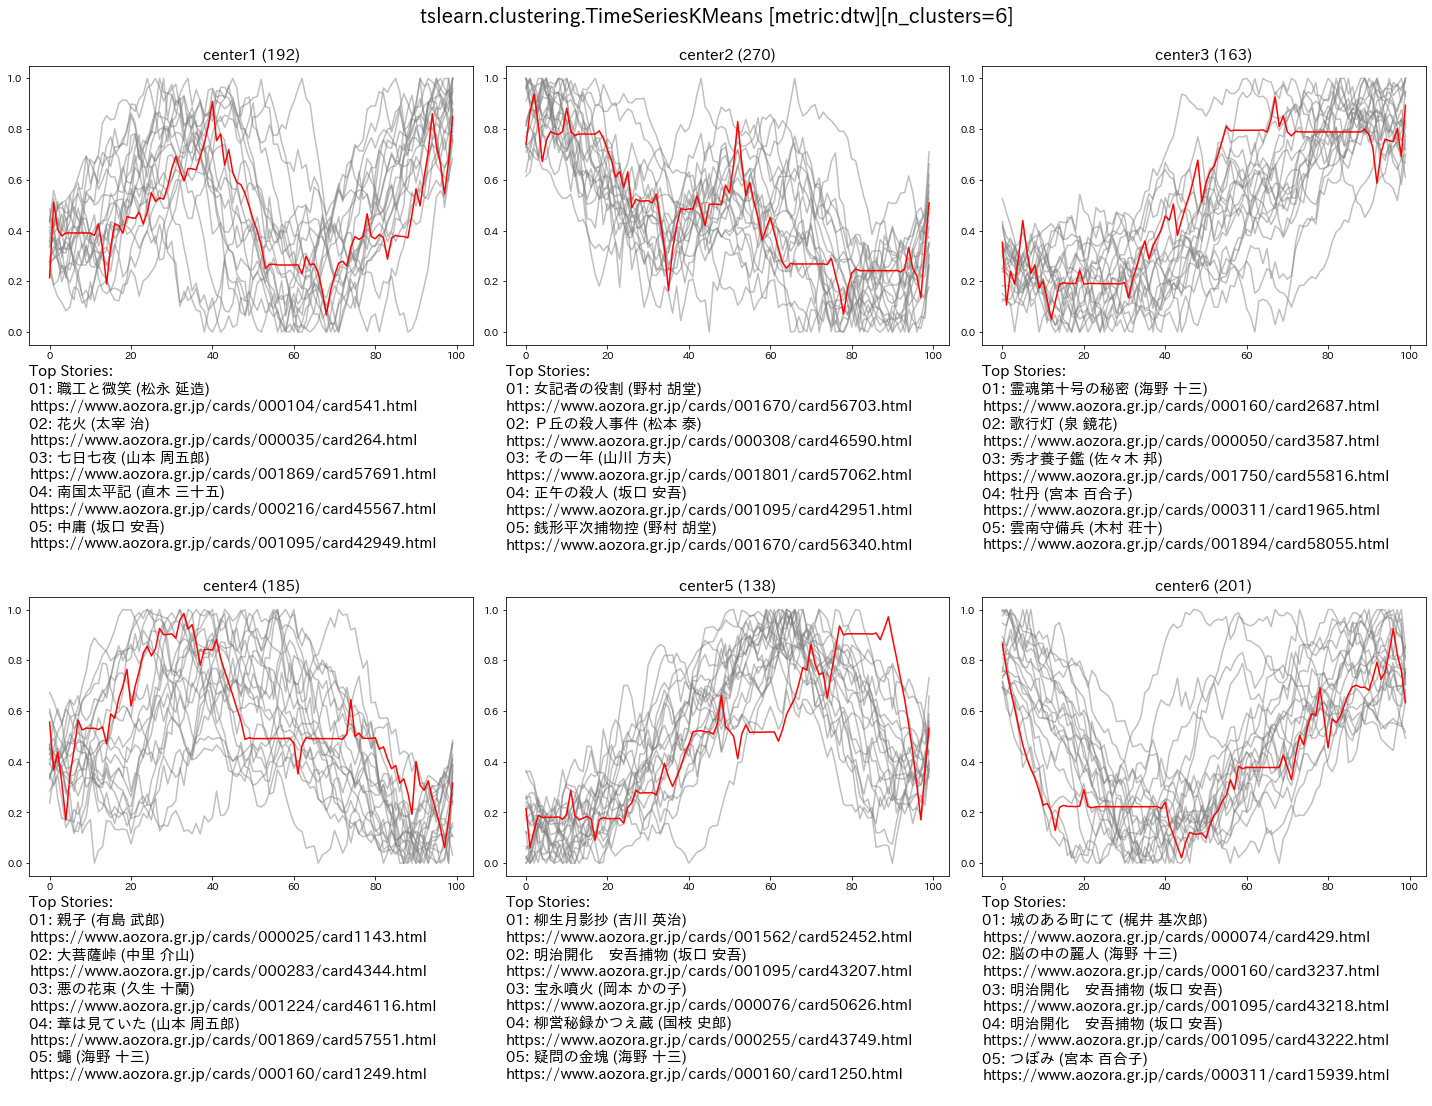

In [34]:
# クラスタとその付近の小説を視覚化
km6.show_cluster_sumples(df_merge, plot_rows=3, plot_cols=3, figsize=(20, 20))

## クラスタ数:7

In [37]:
# クラスタ数:7で実施
file_path = 'data/km7.bin'
if os.path.isfile(file_path):
    km7 = load_instance(file_path)
else:
    km7 = AozoraTSKmeas(7)
    km7.fit_transform(A)
    save_instance(km7, file_path)

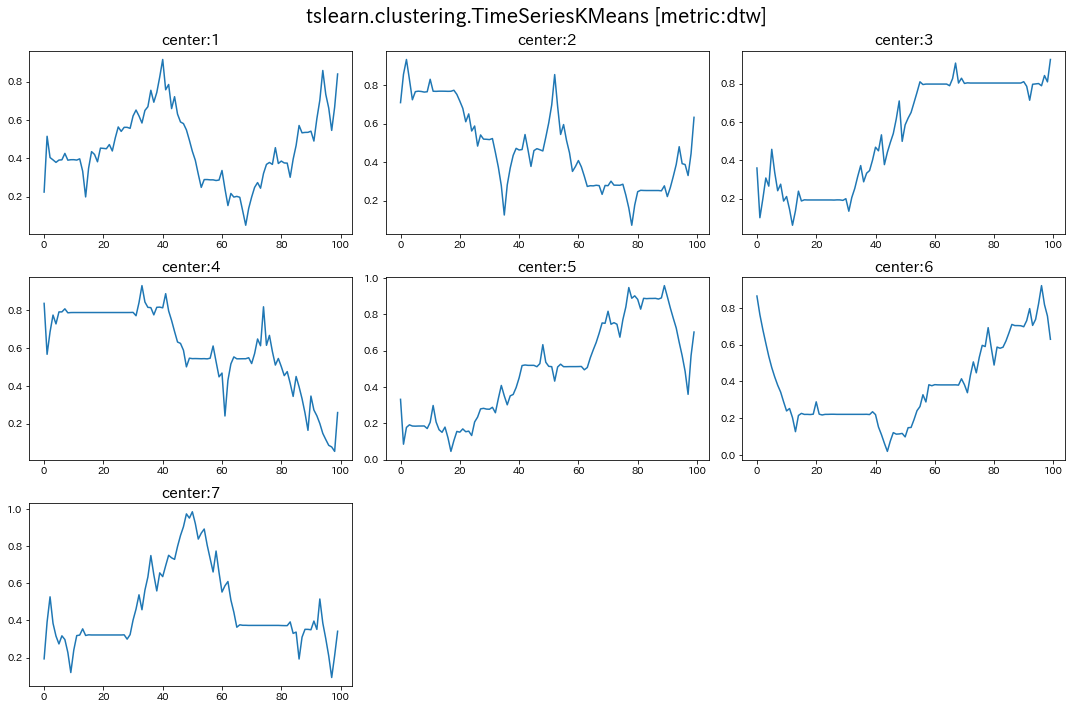

In [38]:
# 視覚化
suptitle = 'tslearn.clustering.TimeSeriesKMeans [metric:dtw]'
km7.show_cluster(suptitle, 'center')

In [39]:
# クラスタ付近の小説を表示
km7.show_novels(df_merge, 5)

CLUSTER NUM:7
NO: 作品名 [副題] (作者,文の長さ)

Top Stories of center1:
01: 花火 (太宰 治,624)
https://www.aozora.gr.jp/cards/000035/card264.html
02: 職工と微笑 (松永 延造,2401)
https://www.aozora.gr.jp/cards/000104/card541.html
03: 中庸 (坂口 安吾,590)
https://www.aozora.gr.jp/cards/001095/card42949.html
04: 七日七夜 (山本 周五郎,536)
https://www.aozora.gr.jp/cards/001869/card57691.html
05: 大菩薩峠 [17 黒業白業の巻] (中里 介山,2192)
https://www.aozora.gr.jp/cards/000283/card4503.html

Top Stories of center2:
01: 明治開化　安吾捕物 [14 その十三　幻の塔] (坂口 安吾,547)
https://www.aozora.gr.jp/cards/001095/card43216.html
02: 女記者の役割 (野村 胡堂,503)
https://www.aozora.gr.jp/cards/001670/card56703.html
03: 神州纐纈城 (国枝 史郎,8497)
https://www.aozora.gr.jp/cards/000255/card1403.html
04: その一年 (山川 方夫,1406)
https://www.aozora.gr.jp/cards/001801/card57062.html
05: 子を奪う (豊島 与志雄,1620)
https://www.aozora.gr.jp/cards/000906/card42408.html

Top Stories of center3:
01: 歌行灯 (泉 鏡花,1250)
https://www.aozora.gr.jp/cards/000050/card3587.html
02: 霊魂第十号の秘密 (海野 十三,1495)
https://www.aozora.

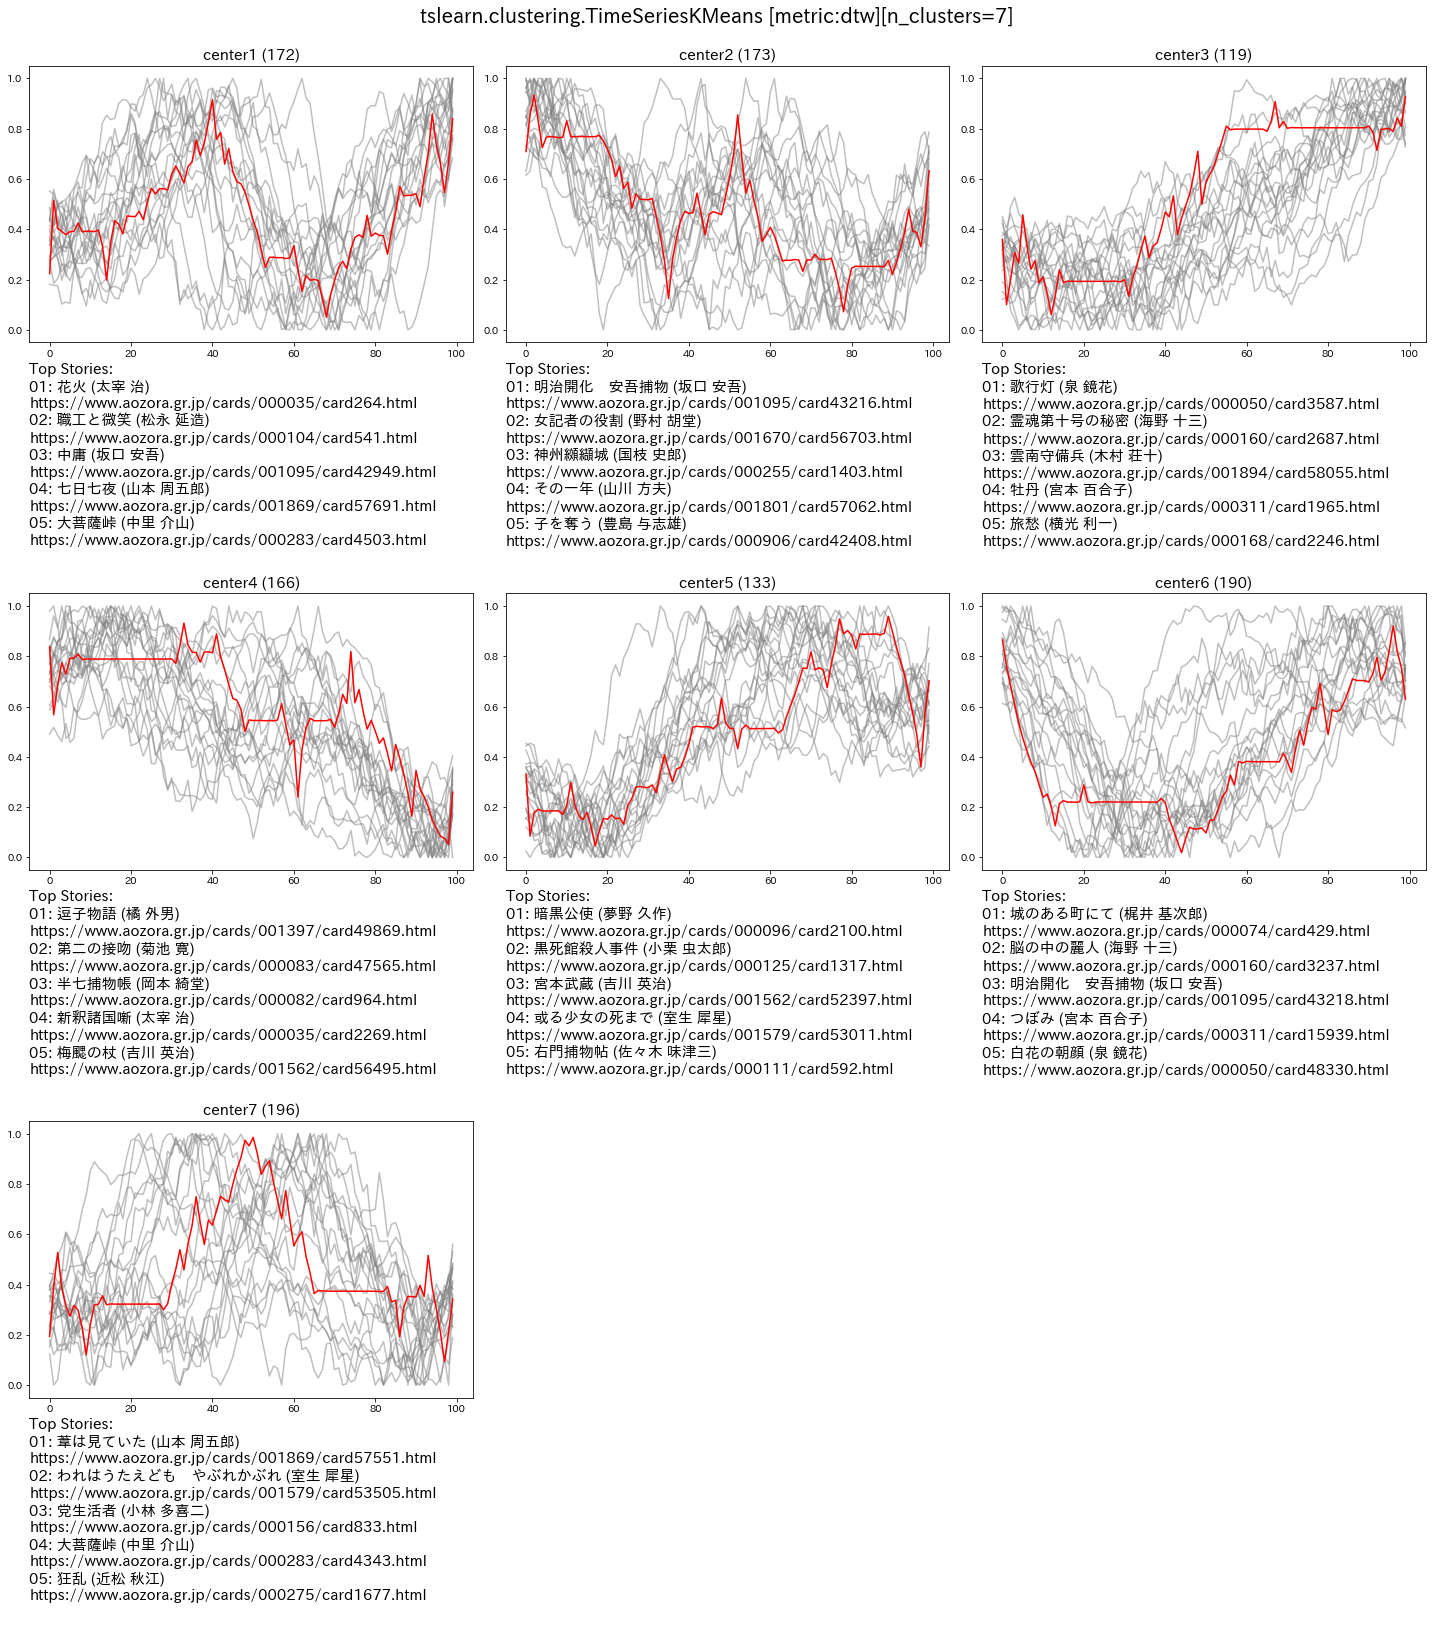

In [40]:
# クラスタとその付近の小説を視覚化
km7.show_cluster_sumples(df_merge, figsize=(20, 23), plot_rows=3, plot_cols=3)

## クラスタ数:8

In [45]:
# クラスタ数:8で実施
file_path = 'data/km8.bin'
if os.path.isfile(file_path):
    km8 = load_instance(file_path)
else:
    km8 = AozoraTSKmeas(8)
    km8.fit_transform(A)
    save_instance(km8, file_path)

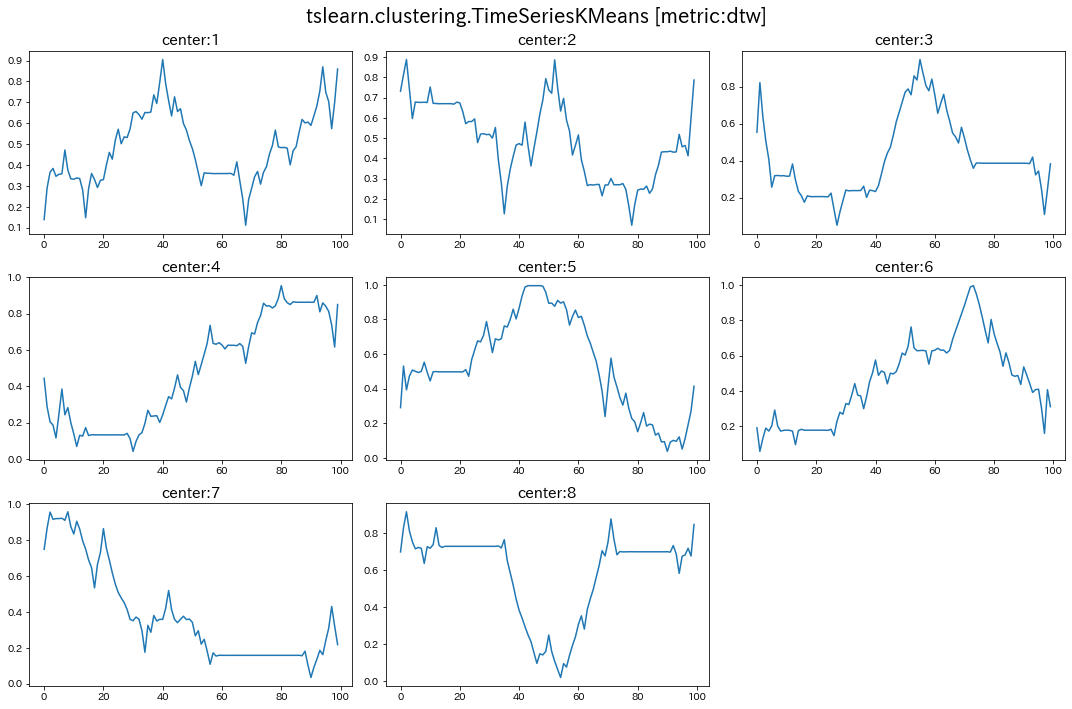

In [46]:
# 視覚化
suptitle = 'tslearn.clustering.TimeSeriesKMeans [metric:dtw]'
km8.show_cluster(suptitle, 'center')

In [47]:
# クラスタ付近の小説を表示
km8.show_novels(df_merge, 5)

CLUSTER NUM:8
NO: 作品名 [副題] (作者,文の長さ)

Top Stories of center1:
01: 職工と微笑 (松永 延造,2401)
https://www.aozora.gr.jp/cards/000104/card541.html
02: 大菩薩峠 [17 黒業白業の巻] (中里 介山,2192)
https://www.aozora.gr.jp/cards/000283/card4503.html
03: 註文帳 (泉 鏡花,893)
https://www.aozora.gr.jp/cards/000050/card48408.html
04: 南国太平記 (直木 三十五,21879)
https://www.aozora.gr.jp/cards/000216/card45567.html
05: 細雪 [01 上巻] (谷崎 潤一郎,2542)
https://www.aozora.gr.jp/cards/001383/card56698.html

Top Stories of center2:
01: 明治開化　安吾捕物 [14 その十三　幻の塔] (坂口 安吾,547)
https://www.aozora.gr.jp/cards/001095/card43216.html
02: 明治開化　安吾捕物 [06 その五　万引家族] (坂口 安吾,753)
https://www.aozora.gr.jp/cards/001095/card43208.html
03: その一年 (山川 方夫,1406)
https://www.aozora.gr.jp/cards/001801/card57062.html
04: 墓地展望亭 (久生 十蘭,1542)
https://www.aozora.gr.jp/cards/001224/card46145.html
05: あらくれ (徳田 秋声,2708)
https://www.aozora.gr.jp/cards/000023/card199.html

Top Stories of center3:
01: 失蝶記 (山本 周五郎,506)
https://www.aozora.gr.jp/cards/001869/card57630.html
02: 大菩薩峠 [11

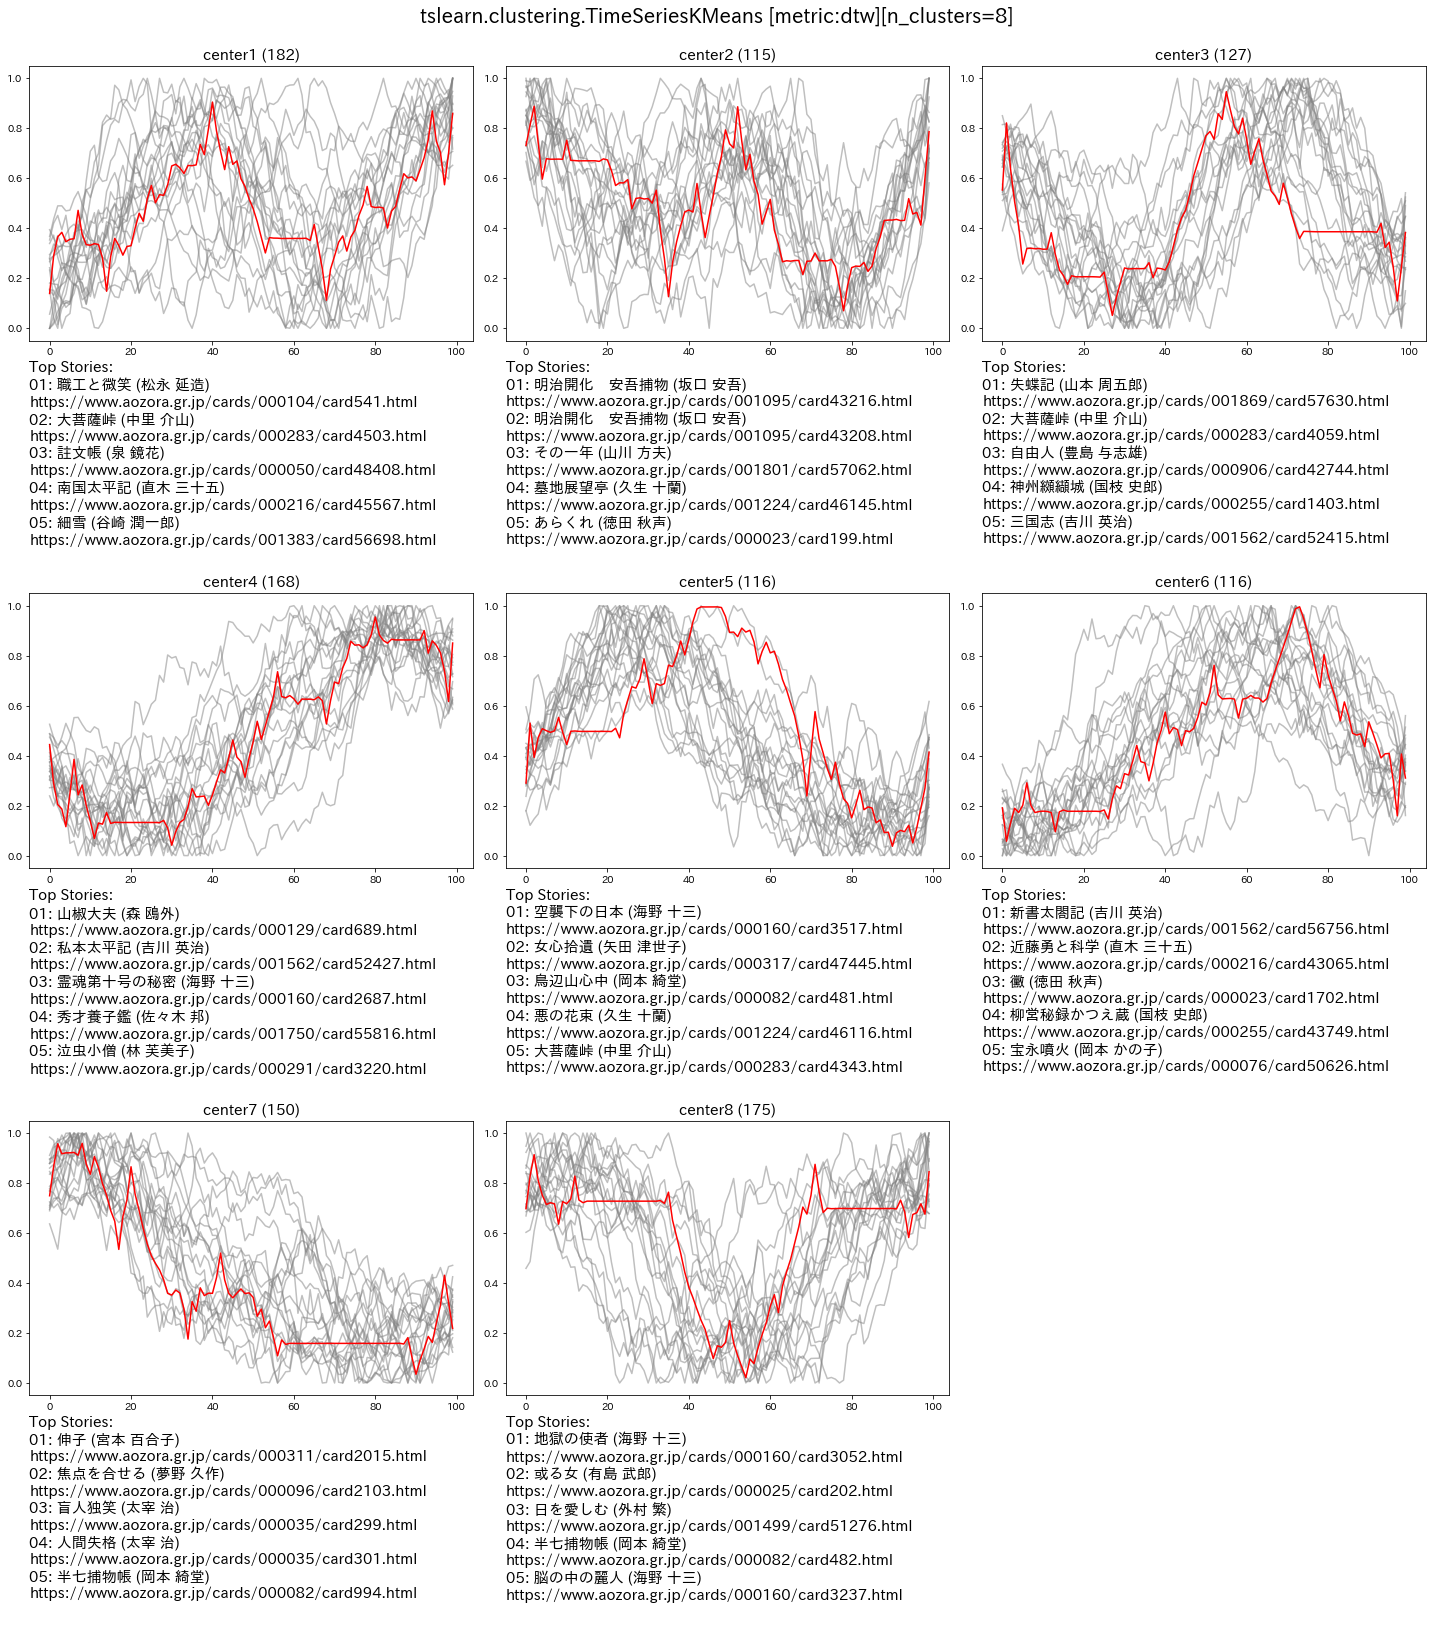

In [48]:
# クラスタとその付近の小説を視覚化
km8.show_cluster_sumples(df_merge, figsize=(20, 23), plot_rows=3, plot_cols=3)

## クラスタ数:9

In [50]:
# クラスタ数:9で実施
file_path = 'data/km9.bin'
if os.path.isfile(file_path):
    km9 = load_instance(file_path)
else:
    km9 = AozoraTSKmeas(9)
    km9.fit_transform(A)
    save_instance(km9, file_path)

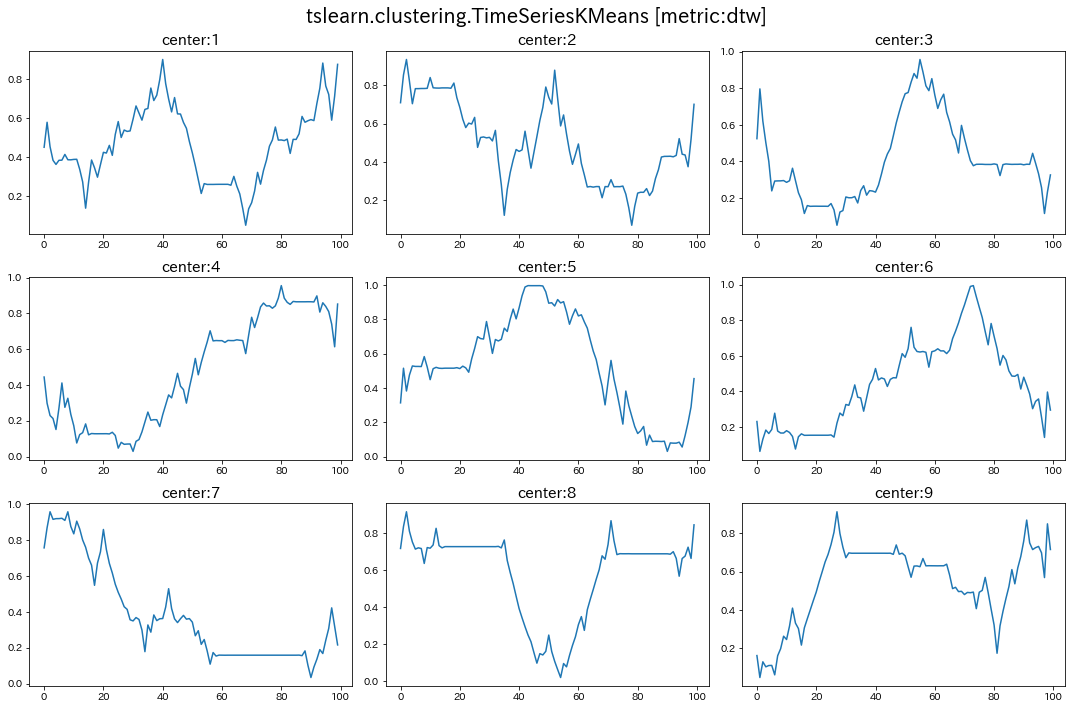

In [51]:
# 視覚化
suptitle = 'tslearn.clustering.TimeSeriesKMeans [metric:dtw]'
km9.show_cluster(suptitle, 'center')

In [52]:
# クラスタ付近の小説を表示
km9.show_novels(df_merge, 5)

CLUSTER NUM:9
NO: 作品名 [副題] (作者,文の長さ)

Top Stories of center1:
01: 大菩薩峠 [17 黒業白業の巻] (中里 介山,2192)
https://www.aozora.gr.jp/cards/000283/card4503.html
02: 光と風と夢 (中島 敦,2513)
https://www.aozora.gr.jp/cards/000119/card1743.html
03: 英本土上陸戦の前夜 (海野 十三,1421)
https://www.aozora.gr.jp/cards/000160/card3356.html
04: 妖婆 (芥川 竜之介,707)
https://www.aozora.gr.jp/cards/000879/card184.html
05: 二十四の瞳 (壺井 栄,3971)
https://www.aozora.gr.jp/cards/001875/card57856.html

Top Stories of center2:
01: その一年 (山川 方夫,1406)
https://www.aozora.gr.jp/cards/001801/card57062.html
02: 明治開化　安吾捕物 [14 その十三　幻の塔] (坂口 安吾,547)
https://www.aozora.gr.jp/cards/001095/card43216.html
03: 神州纐纈城 (国枝 史郎,8497)
https://www.aozora.gr.jp/cards/000255/card1403.html
04: キャラコさん [03 蘆と木笛] (久生 十蘭,691)
https://www.aozora.gr.jp/cards/001224/card47488.html
05: 甲乙 (泉 鏡花,617)
https://www.aozora.gr.jp/cards/000050/card48402.html

Top Stories of center3:
01: 失蝶記 (山本 周五郎,506)
https://www.aozora.gr.jp/cards/001869/card57630.html
02: 湯島詣 (泉 鏡花,1676)
https://w

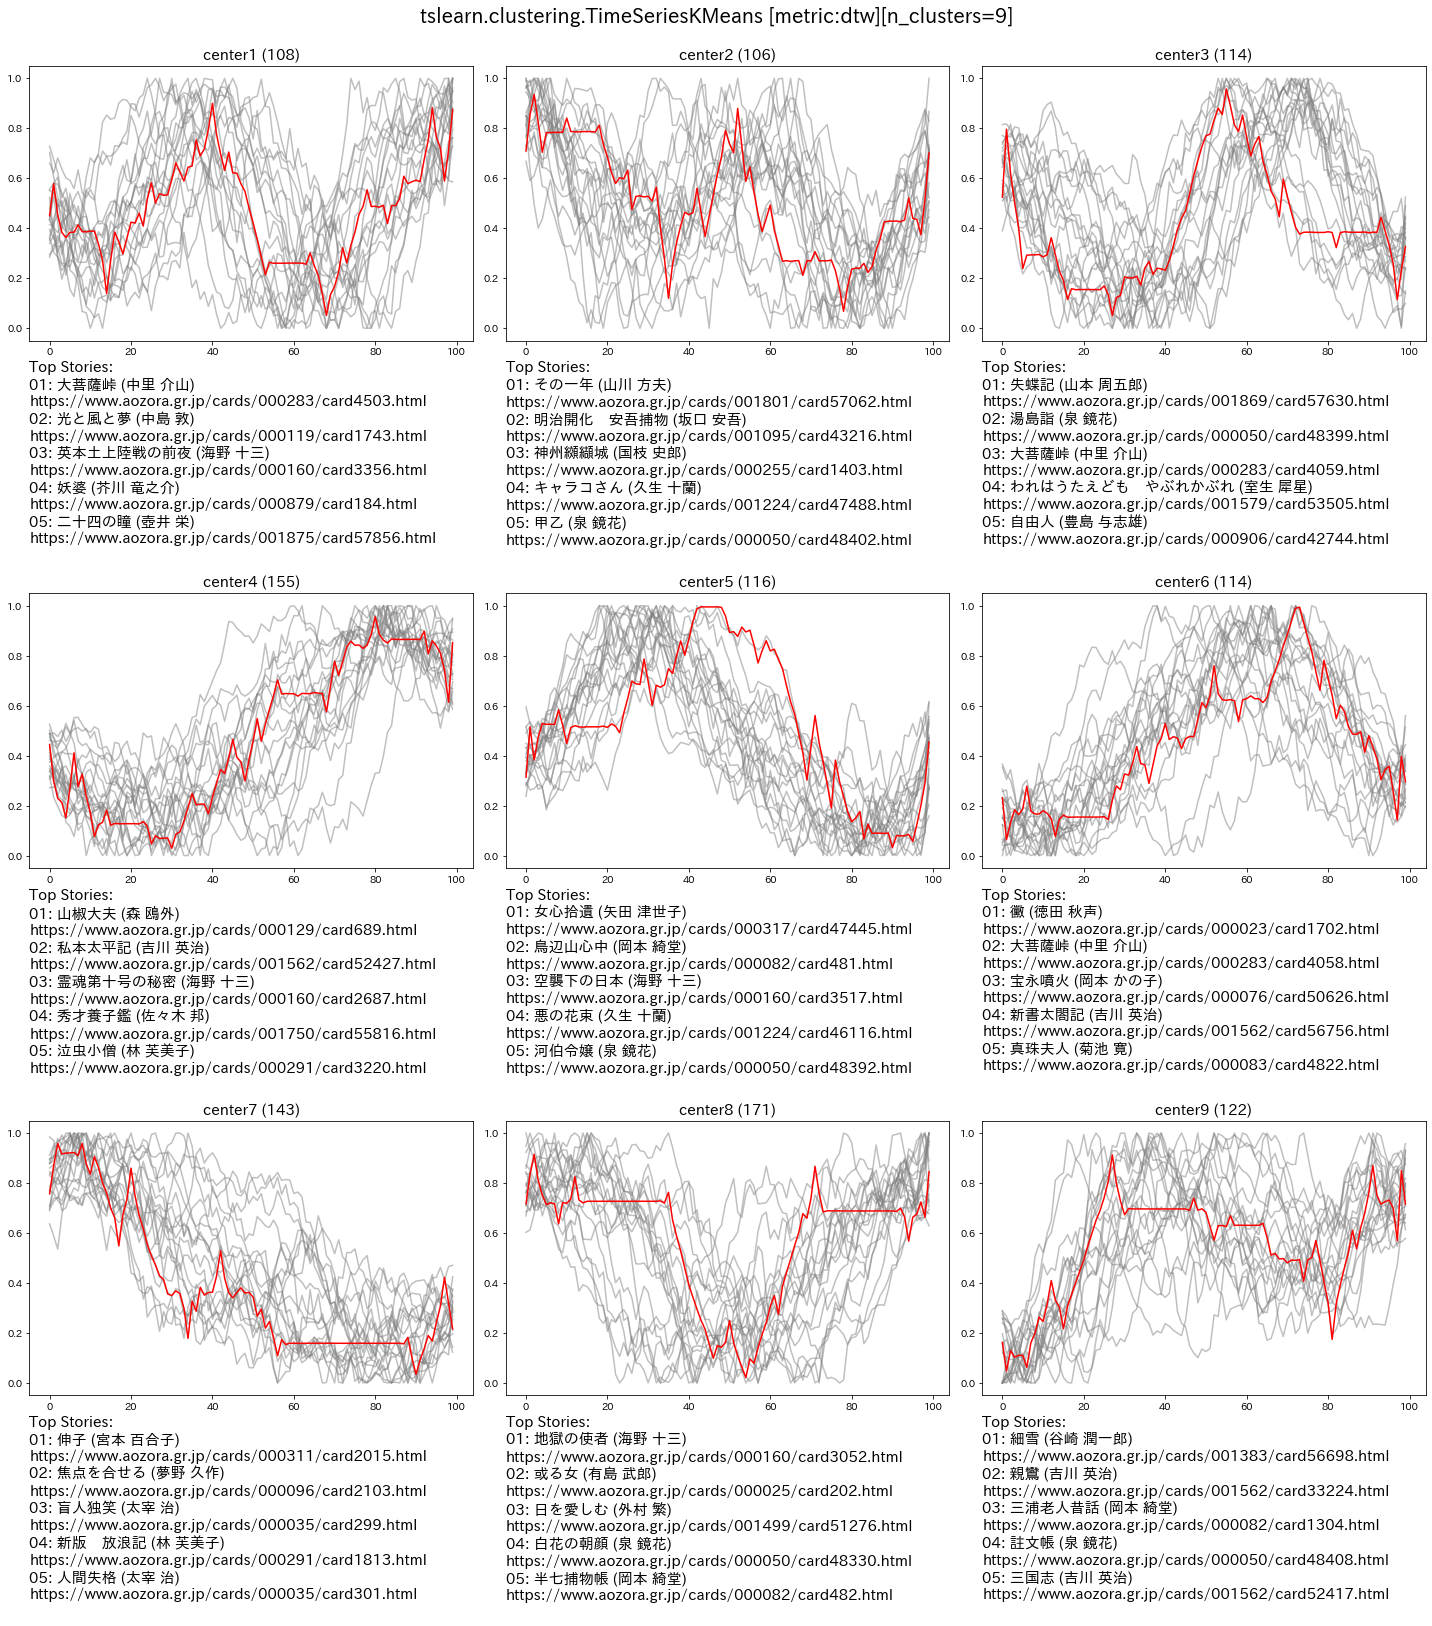

In [53]:
# クラスタとその付近の小説を視覚化
km9.show_cluster_sumples(df_merge, figsize=(20, 23), plot_cols=3)